### Предсказательная сила дополнительных показателей в спортивном "Что? Где? Когда?"
Забор данных с турнирного сайта, расчёт метрик точности и исследование предсказательной силы

In [1]:
import psycopg2 as ps
import pandas as pd
import numpy as np

import requests
import json
import io

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

from pylab import rcParams

from sklearn.metrics import ndcg_score, accuracy_score
import random
import time

import chgk_api as cha

rcParams['figure.figsize'] = 8, 5

# настройки pandas, с которыми лучше почти всегда
pd.set_option('display.max_rows', 45000)
pd.set_option('display.max_columns', 50000)
pd.set_option('display.max_colwidth', 5000)

### Настройки и параметры

In [2]:
# количество вопросов "виртуальной перестрелки", кототорое планируем моделировать
test_distnce = 8

# процентили, на которые мы разделили выборрку турнира по стартовому рейтингу
first_percentile = 0.1
second_percentile = 0.5

# процентили, на которые мы разделили выборрку турниров по сложности
dl_border1 = 0.33
dl_border2 = 0.66

# процентили, на которые мы разделили выборрку турниров по числу участников
size_border1 = 0.1
size_border2 = 0.5

# количество команд, которые участвуют в построении метрики
k_opt = 800

# тестовый период для проверки работы функций
test_start_date = '2025-02-01'
test_finish_date = '2025-02-15'

# продовое время для обработки биг даты
start_date = '2022-01-01'
finish_date = '2025-03-01'

# режим работы с данными: тянуть свежее по api (примерно 4 часа) или взять устаревшие данные из файла
# data_work_option = 'api'
data_work_option = 'file'

# настройки цветов графиков
colors = plt.colormaps['Set1']
metric_dict = {
    'ndcg_start_rating_forecast': {'name': 'Стартовый рейтинг', 'color': colors(1)},  
    'ndcg_shuffle_forecast': {'name': 'Случайная тасовка', 'color': colors(0)},  
    'ndcg_current_place_forecast': {'name': 'Занятое место', 'color': colors(5)},  
    'ndcg_qv_rating_place_forecast': {'name': 'Рейтинг взятых вопросов', 'color': colors(2)},  
    'ndcg_tours_sum_forecast': {'name': 'Сумма мест в турах', 'color': colors(4)},  
}

### Кастомные функции

In [3]:
def make_metrics(
                    df, 
                    segment_col, target_col, pred_col, 
                    k=5, is_size=True, suffix='', 
                    param_value='', param_col='', 
                    tourn_id=0
                ):
    """
    Функция для точности прогноза. 
    Сейчас это ndcg_score https://scikit-learn.org/dev/modules/generated/sklearn.metrics.ndcg_score.html
    """
    work_df = df.copy()
    work_df.sort_values(by=[target_col, segment_col], ascending=[True, True])
    grouped = work_df.groupby(segment_col)
    ndcg_lst = []
    acc_lst = []

    for name, group in grouped:
        group = group.sort_values(by=target_col)
        y_true = np.array([group[target_col]])
        y_pred = np.array([group[pred_col]])
        
        ndcg = ndcg_score(y_true, y_pred, k=k)
        ndcg_lst.append({segment_col: name, 'ndcg': ndcg})

        # accuracy_score не работает с float, 
        # поэтому округляем вниз, делённое место считаем целевым
        y_true = np.floor(y_true).astype('int')
        y_pred = np.floor(y_pred).astype('int')

        acc = accuracy_score(y_true[0], y_pred[0])
        acc_lst.append({segment_col: name, 'accuracy': acc})

    metrics_df = work_df.groupby(segment_col).agg(
                                                    size = ('team_id', 'nunique'),
                                                    ).reset_index()
    ndcg_df = pd.DataFrame(ndcg_lst)
    acc_df = pd.DataFrame(acc_lst)

    metrics_df = metrics_df.merge(ndcg_df, 'left', on=segment_col)
    metrics_df = metrics_df.merge(acc_df, 'left', on=segment_col)

    if is_size == False:
        del metrics_df['size']
        metrics_df.columns = ['segment', 'ndcg'+suffix, 'accuracy'+suffix]
    else:
        metrics_df.columns = ['segment', 'size', 'ndcg'+suffix, 'accuracy'+suffix]
    
    metrics_df['tourn_id'] = tourn_id
    metrics_df[param_col] = param_value

    return metrics_df

def get_target(df):
    """
    Функция для расчёта целевой метрики
    Сейчас - это ранг суммы взятых с усреднением
    """
    totals_df = df.groupby(['tourn_id', 'team_id']).agg(
        target_question = ('qv_result', 'sum'),
    ).reset_index()
    totals_df['target'] = totals_df.groupby(['tourn_id'])['target_question'].rank(method='average', ascending=False)

    return totals_df

def get_current_taken_forecast(df, qv_num, segment_col):
    """
    Функция для расчёта прогноза "по взятым".
    В конце турнира команда займёт такое место, какое занимает на этап после qv_num вопроса
    """
    gr_df = df[df['question_num'] <= qv_num].groupby(['tourn_id', 'team_id', segment_col]).agg(
        current_res = ('qv_result', 'sum'),
    ).reset_index()

    totals_df = get_target(df)
    gr_df = gr_df.merge(totals_df, 'left', on=['tourn_id', 'team_id'])
    gr_df['current_place'] = gr_df.groupby(['tourn_id'])['current_res'].rank(method='average', ascending=False)
    gr_df = gr_df.sort_values(by='target_question', ascending=False)

    return gr_df

def get_current_qv_rating_forecast(df, qv_num, segment_col):
    """
    Функция для расчёта прогноза "по рейтингу взятых вопросов".
    В конце турнира команда займёт такое место, какое занимает на этап после qv_num по рейтингу взятых
    """
    # статистика по вопросам
    qv_stat_df = df.groupby(['tourn_id', 'question_num']).agg(
        taked = ('qv_result', 'sum'),
        total = ('qv_result', 'count'),
    ).reset_index()
    # рейтинг вопроса - количество команд, которые его не взяли
    qv_stat_df['qv_rating'] = qv_stat_df['total'] - qv_stat_df['taked']

    qv_df = df.merge(qv_stat_df, 'left', on=['tourn_id', 'question_num'])
    # вопросный рейтинг команды - суммарный рейтинг вопросов, которые она взяла  
    qv_df['rating'] = qv_df['qv_rating'] * qv_df['qv_result'] 

    gr_df = qv_df[qv_df['question_num'] <= qv_num].groupby(['tourn_id', 'team_id', segment_col]).agg(
        current_rating = ('rating', 'sum'),
    ).reset_index()
    gr_df['rating_place'] = gr_df.groupby(['tourn_id'])['current_rating'].rank(method='average', ascending=False)

    totals_df = get_target(df)

    gr_df = gr_df.merge(totals_df, 'left', on=['tourn_id', 'team_id'])

    return gr_df


def get_tours_distr(json_data):
    """
    Собираем структуру турнира по json из API
    """
    size = len(json_data)
    qv_lst = []
    tour_lst = []
    max_qv = 0
    for t in range(1, size+1):
        rr = range(max_qv+1, max_qv+json_data[str(t)]+1)
        max_qv = rr[-1]
        for q in rr:
            qv_lst.append(q)
            tour_lst.append(t)
    
    df = pd.DataFrame(qv_lst, columns=['question_num'])
    df['tour_id'] = tour_lst
    return df


def get_tours_res_forecast(df, qv_num, segment_col):
    """
    Функция для расчёта прогноза по сумме мест в турах
    """
    tours_distr = get_tours_distr(df['questionQty'].values[0])
    df = df.merge(tours_distr, 'left', on='question_num')

    gr_df = df[df['question_num'] <= qv_num].groupby(['tourn_id', 'team_id', 'tour_id', segment_col]).agg(
        current_res = ('qv_result', 'sum'),
    ).reset_index()

    gr_df['tour_place'] = gr_df.groupby(['tourn_id', 'tour_id'])['current_res'].rank(method='average', ascending=False)
    
    tr_df = gr_df.groupby(['tourn_id', 'team_id', segment_col]).agg(
        tour_placses = ('tour_place', 'sum'),
    ).reset_index()
    tr_df['tour_forecast'] = tr_df.groupby(['tourn_id'])['tour_placses'].rank(method='average', ascending=True)

    totals_df = get_target(df)
    tr_df = tr_df.merge(totals_df, 'left', on=['tourn_id', 'team_id'])
    tr_df = tr_df.sort_values(by='target_question', ascending=False)

    return tr_df

def get_data(tourn_id):
    """
    Функция для сборки датасета и проставлении необходимых полей
    """
    # получаем данные по API
    tourn_df, question_df, players_df = cha.get_tourn_result(tourn_id)
    qv_stat = cha.tourn_stat(question_df)

    # назначаем командам сегмент по стартовой крутости
    tourn_df['segment'] = np.where(
        (tourn_df['predictedPosition'] <= tourn_df['predictedPosition'].quantile(.1)), '1.top_10%',
        np.where(
                    (tourn_df['predictedPosition'] <= tourn_df['predictedPosition'].quantile(.5)) &
                    (tourn_df['predictedPosition'] > tourn_df['predictedPosition'].quantile(.1)), '2.top_50%', '3.bottom_50%'
                )
                                )
    

    # собираем нужный датасет
    work_df = qv_stat.merge(tourn_df[['tourn_id', 'team_id', 'predictedPosition', 'position', 'segment']], 'left', on=['tourn_id', 'team_id'])
    work_df['qv_result'] = work_df['qv_result'].astype('int')

    work_df = work_df.sort_values(by=['tourn_id', 'predictedPosition', 'segment', 'team_id', 'question_num'])

    return tourn_df, question_df, players_df, work_df

def get_tourn_stat(work_df):
    """
    Функция которая для каждого вопроса турнира считает по двум метрикам (точность и ndcg) следующие прогнозы
    - случайная тасовка команд
    - прогноз по стартовому рейтингу
    - прогноз по текущему месту
    - прогноз по текущему рейтингу
    - прогноз по сумме мест в туре
    """
    # собранный датассет по одному турниру
    tourn_id = work_df['tourn_id'].values[0]

    num_of_questions = work_df['numqv'].values[0]
    num_of_teams = work_df['team_id'].nunique()

    questions = pd.DataFrame(range(1, num_of_questions+1), columns=['question_num'])
    questions['tourn_id'] = tourn_id

    # прогноз по стартовому рейтингу
    teams_smpl = work_df[['tourn_id', 'team_id', 'position', 'predictedPosition', 'segment']].drop_duplicates()
    start_df_forec = make_metrics(
                    teams_smpl, 
                    segment_col='segment', 
                    target_col='position', 
                    pred_col='predictedPosition', 
                    is_size=True, 
                    k=k_opt,
                    suffix='_start_rating_forecast', 
                    tourn_id=tourn_id)

    res_df = questions.merge(start_df_forec, 'left', on='tourn_id')

    # прогноз по случайной тасовке команд
    places= list(range(1, len(teams_smpl)+1))
    random.shuffle(places)
    teams_smpl['random'] = places
    shuffle_forecast = make_metrics(
                    teams_smpl, 
                    segment_col='segment', 
                    target_col='position', 
                    pred_col='random', 
                    is_size=False, 
                    k=k_opt,
                    suffix='_shuffle_forecast', 
                    tourn_id=tourn_id)


    res_df = res_df.merge(shuffle_forecast, 'left', on=['segment'], suffixes=('', '_random'))

    qv_forecast_metric_df = pd.DataFrame()
    rating_forecast_metric_df = pd.DataFrame()
    tours_sum_forecast_metric_df = pd.DataFrame()
    for i in range(1, num_of_questions+1):
        qv_forecast_df = get_current_taken_forecast(work_df, i, 'segment')
        rating_forecast_df = get_current_qv_rating_forecast(work_df, i, 'segment')
        tours_sum_forecast_df = get_tours_res_forecast(work_df, i, 'segment')

        qv_forecast_metric_df_b = make_metrics(
                        qv_forecast_df, 
                        segment_col='segment', 
                        target_col='target', 
                        pred_col='current_place', 
                        is_size=False, 
                        k=k_opt,
                        suffix='_current_place_forecast', 
                        param_value=i,
                        param_col='question_num', 
                        tourn_id=tourn_id)
        
        rating_forecast_metric_df_b = make_metrics(
                        rating_forecast_df, 
                        segment_col='segment', 
                        target_col='target', 
                        pred_col='rating_place', 
                        is_size=False, 
                        k=k_opt,
                        suffix='_qv_rating_place_forecast', 
                        param_value=i,
                        param_col='question_num', 
                        tourn_id=tourn_id)
        
        tours_sum_forecast_metric_df_b = make_metrics(
                        tours_sum_forecast_df, 
                        segment_col='segment', 
                        target_col='target', 
                        pred_col='tour_forecast', 
                        is_size=False, 
                        k=k_opt,
                        suffix='_tours_sum_forecast', 
                        param_value=i,
                        param_col='question_num', 
                        tourn_id=tourn_id)

        qv_forecast_metric_df = pd.concat([qv_forecast_metric_df, qv_forecast_metric_df_b])
        rating_forecast_metric_df = pd.concat([rating_forecast_metric_df, rating_forecast_metric_df_b])
        tours_sum_forecast_metric_df = pd.concat([tours_sum_forecast_metric_df, tours_sum_forecast_metric_df_b])

    res_df = res_df.merge(qv_forecast_metric_df, 'left', on=['tourn_id', 'segment', 'question_num'])
    res_df = res_df.merge(rating_forecast_metric_df, 'left', on=['tourn_id', 'segment', 'question_num'])
    res_df = res_df.merge(tours_sum_forecast_metric_df, 'left', on=['tourn_id', 'segment', 'question_num'])

    # в качестве прогноза берём ситуацию перед начало "виртуальной перестрелки"
    forec_df = res_df[res_df['question_num'] == num_of_questions - test_distnce]

    return res_df, forec_df


def make_main_process(data_work_option, start_date, finish_date):
    """
    Процесс сбора больших данных и расчёта метрик
    """
    # режим забора свежих данных по api
    if data_work_option == 'api':
        # полный список турниров за период
        # там ещё уникальные параметры турниров передаются (которые по апи самого турнира не достать)
        tourn_lst_df = pd.DataFrame()
        # апи на машстабах от полугода до года где-то падает
        # нарежем по месяцам, чтобы наверняка 
        periods = pd.date_range(start=start_date, end=finish_date, freq='ME')

        for i in range(len(periods)-1):
            print(periods[i])
            # а ещё тут есть пагинация
            # и ни одного штатного способа узнать количество страниц я не вижу, поэтому ставим "с запасом"
            for page in range(1, 100):
                print(page)
                # тут бы два обработчика: когда страницы кончились и на прочие ошибки
                try:
                    tourn_lst_df_pag = cha.get_tourn_list(periods[i], periods[i+1], page)
                    print("Число турниров в порции: ", len(tourn_lst_df_pag))
                    tourn_lst_df = pd.concat([tourn_lst_df, tourn_lst_df_pag])
                except:
                    break

        print("Общее число турниров в наборе: ", len(tourn_lst_df))

        # по всем турнирам
        res_df = pd.DataFrame()
        forec_df = pd.DataFrame()
        for tourn_id in tourn_lst_df['tourn_id'].unique():
            print(tourn_id)
            try:
                tourn_df, question_df, players_df, work_df = get_data(tourn_id)
                work_df = work_df.merge(tourn_lst_df, on='tourn_id')
                res_df_b, forec_df_b = get_tourn_stat(work_df)
                res_df = pd.concat([res_df, res_df_b])
                forec_df = pd.concat([forec_df, forec_df_b])
                # текущий лимит: 2 запроса в секунду, так что это с запасом
                time.sleep(1)
            except Exception as e:
                print(str(tourn_id), ": ", str(e))

        # пишем в файл, чтобы не насиловать апи каждый раз
        res_df.to_csv('res_df')
        forec_df.to_csv('forec_df')
        tourn_lst_df.to_csv('tourn_lst_df')
    # режим работы со страыми данными из файла
    elif data_work_option == 'file': 
        res_df = pd.read_csv('res_df')
        forec_df = pd.read_csv('forec_df')
        tourn_lst_df = pd.read_csv('tourn_lst_df')


    forec_df = forec_df.merge(tourn_lst_df, 'left', on='tourn_id')

    forec_df['dl_segment'] = np.where(
                                    (forec_df['trueDL'] <= forec_df['trueDL'].quantile(dl_border1)), '1.Easy',
                                    np.where(
                                    (forec_df['trueDL'] > forec_df['trueDL'].quantile(dl_border1)) & 
                                    (forec_df['trueDL'] <= forec_df['trueDL'].quantile(dl_border2)), '2. Normal', '3. Hard' 
                                            )
                                    )

    forec_df['size_segment'] = np.where(
                                    (forec_df['size'] <= forec_df['size'].quantile(size_border1)), '1. Small',
                                    np.where(
                                    (forec_df['size'] > forec_df['size'].quantile(size_border1)) & 
                                    (forec_df['size'] <= forec_df['size'].quantile(size_border2)), '2. Normal', '3. Big' 
                                            )
                                    )

    forec_df['distance'] = forec_df['question_num'] + test_distnce

    return res_df, forec_df, tourn_lst_df


def make_norm_metrics(df, fields):
    """
    Функция для получения взвешенного среднего по метрикам точности
    """
    forec_df = df.copy()
    # список метрик, которые будем считать
    metric_cols = []
    for col in forec_df.columns:
        if ('ndcg' in col) or ('accuracy' in col):
            metric_cols.append(col)   
    metric_cols.sort()

    # умножаем значение метрики на размер сегмента
    for metric in metric_cols:
        forec_df[metric] = forec_df[metric] * forec_df['size']

    # словарь, с помощью которого можно весь список метрик запихнуть в pd.groupby
    metric_cols.append('size')
    agg_dict = {col: (col, 'sum') for col in metric_cols}

    # в нужной агрегации просуммируем
    group_res_df = forec_df.groupby(fields).agg(**agg_dict).reset_index()
    # а потом снова разделим на итог
    # будет средневзвешенное по сегменту
    for metric in metric_cols:
        if metric != 'size':
            group_res_df[metric] = group_res_df[metric] / group_res_df['size']


    return group_res_df

def make_base_vis(forec_df, segment, metric_dict):
    """
    Построение основных визуализаций для понимания точности 
    """
    vis_df = make_norm_metrics(forec_df, segment)
    
    col_to_vis = list(metric_dict.keys())
    for col in segment:
        col_to_vis.append(col)
    vis_df = vis_df[col_to_vis]

    vis_df.set_index(segment, inplace=True)

    # Создаем график
    plt.figure(figsize=(10, 6))

    # Добавляем линии для каждой метрики из словаря
    for metric, properties in metric_dict.items():
        plt.hlines(y=vis_df[metric], xmin=[x for x in range(len(vis_df))], xmax=[x + 0.8 for x in range(len(vis_df))],
                colors=properties['color'], linewidth=4, label=properties['name'])

    # Настраиваем график
    plt.title('Сравнение точности прогноза по ' + str(segment))
    plt.xlabel(str(segment))
    plt.ylabel('NDSG')
    plt.xticks(ticks=range(len(vis_df)), labels=vis_df.index, rotation=45, ha='right')
    plt.legend(title='Тип прогноза', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    # Показываем график
    plt.show()


def vis_one_tourn(res_df, tourn_id):
    """
    И повопросная таблица для одного турнира
    """
    current_tourn_df = res_df[
                                (res_df['tourn_id'] == tourn_id)
                            ]
    currnt_tourn_name = current_tourn_df['tourn_name'].values[0]
    
    for segment in current_tourn_df['segment'].unique():
        df_to_show = current_tourn_df[
                                    (current_tourn_df['segment'] == segment)
                                    ].set_index('question_num')[metric_dict.keys()]
        ax = df_to_show.plot(
                        title=currnt_tourn_name + ": " + segment, 
                        color=[metric_dict[col]['color'] for col in metric_dict.keys()]
                            )
        
        # Добавление вертикальной пунктирной линии
        position = np.max(current_tourn_df['question_num']) - test_distnce
        ax.axvline(x=position, color='red', linestyle='--', linewidth=2, label='Начало виртуальной перестрелки')


        handles = [plt.Line2D([0], [0], color=metric_dict[col]['color'], lw=4, label=metric_dict[col]['name']) for col in metric_dict.keys()]
        ax.legend(handles=handles, title='Метрики', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=3)
        
        plt.xlabel('Номер вопроса')
        plt.ylabel('NDCG')
        plt.tight_layout()
        plt.show()  

### Тестовый прогон на небольшом числе турниров
И демонстрация расчёта метрик

In [4]:
# проверяем работу функций
# список турниров за определённую дату, первая страница пагинации
tourn_lst_df = cha.get_tourn_list(test_start_date, test_finish_date, 1)
tourn_lst_df.sample(3)

Status code:  200


,tourn_id,tourn_name,type,season,difficulty_forecast,is_rating,trueDL,questionQty
1,10490,Куб-6. Февраль,Синхрон,59,4.5,True,4.22776,"{'1': 12, '2': 12, '3': 12}"
6,11745,Кубок Сигулды `25,Обычный,59,5.0,True,5.44830,"{'1': 15, '2': 15, '3': 15, '4': 15, '5': 15, '6': 15}"
0,9825,Синхрон Моносова 28 (синхрон),Синхрон,59,0.0,True,5.67129,"{'1': 12, '2': 12, '3': 12}"


In [5]:
# собранный датассет по одному турниру
tourn_id = tourn_lst_df['tourn_id'].values[5]
tourn_df, question_df, players_df, work_df = get_data(tourn_id)
work_df = work_df.merge(tourn_lst_df, on='tourn_id')
work_df.sample(3)

Status code:  200


,tourn_id,team_id,numqv,question_num,qv_result,predictedPosition,position,segment,tourn_name,type,season,difficulty_forecast,is_rating,trueDL,questionQty
3446,11512,88112,36,27,0,96,106.0,3.bottom_50%,Кубок Эквестрии — 30 (синхрон),Синхрон,59,3.5,True,4.23808,"{'1': 12, '2': 12, '3': 12}"
3589,11512,103467,36,26,1,100,89.5,3.bottom_50%,Кубок Эквестрии — 30 (синхрон),Синхрон,59,3.5,True,4.23808,"{'1': 12, '2': 12, '3': 12}"
2266,11512,92931,36,35,1,63,21.0,2.top_50%,Кубок Эквестрии — 30 (синхрон),Синхрон,59,3.5,True,4.23808,"{'1': 12, '2': 12, '3': 12}"


In [6]:
# прогноз по занятому месту к 12 вопросу по сегменту стартовой крутости
grtf = get_current_taken_forecast(work_df, 12, 'segment')
grtf.sample(3)

,tourn_id,team_id,segment,current_res,target_question,target,current_place
55,11512,70945,3.bottom_50%,8,19,70.0,60.0
98,11512,95594,3.bottom_50%,4,10,125.0,126.0
136,11512,103996,3.bottom_50%,0,6,135.0,142.0


In [7]:
# метрики точности прогноза по сегментам
make_metrics(
                grtf, 
                segment_col='segment', 
                target_col='target', 
                pred_col='current_place', 
                is_size=True, 
                k=k_opt,
                suffix='_current_taken', 
                tourn_id=tourn_id)

,segment,size,ndcg_current_taken,accuracy_current_taken,tourn_id,
0,1.top_10%,15,0.969348,0.000000,11512,
1,2.top_50%,56,0.939362,0.000000,11512,
2,3.bottom_50%,71,0.992673,0.014085,11512,


In [8]:
# по всей выборке тоже можно сделать
make_metrics(
                grtf, 
                segment_col='tourn_id', 
                target_col='target', 
                pred_col='current_place', 
                is_size=True, 
                suffix='_current_taken', 
                tourn_id=tourn_id)

,segment,size,ndcg_current_taken,accuracy_current_taken,tourn_id,
0,11512,142,0.982999,0.007042,11512,


In [9]:
# прогноз по рейтингу взятых вопросов к 12 вопросу по сегменту стартовой крутости
gcqrf = get_current_qv_rating_forecast(work_df, 12, 'segment')
gcqrf.sample(3)

,tourn_id,team_id,segment,current_rating,rating_place,target_question,target
76,11512,90990,3.bottom_50%,591,7.0,20,61.5
14,11512,44079,1.top_10%,500,24.5,26,21.0
64,11512,87812,3.bottom_50%,293,90.5,15,95.5


In [10]:
# метрики точности прогноза по сегментам
make_metrics(
                gcqrf, 
                segment_col='segment', 
                target_col='target', 
                pred_col='rating_place', 
                is_size=True, 
                suffix='_qv_rating_forecast', 
                tourn_id=tourn_id)

,segment,size,ndcg_qv_rating_forecast,accuracy_qv_rating_forecast,tourn_id,
0,1.top_10%,15,0.984674,0.000000,11512,
1,2.top_50%,56,0.762018,0.035714,11512,
2,3.bottom_50%,71,0.976625,0.014085,11512,


In [11]:
# прогноз по сумме мест в турах к 12 вопросу по сегменту стартовой крутости
gtrf = get_tours_res_forecast(work_df, 12, 'segment')
gtrf.sample(3)

,tourn_id,team_id,segment,tour_placses,tour_forecast,target_question,target
117,11512,100097,3.bottom_50%,137.0,137.0,4,140.0
77,11512,91036,1.top_10%,79.5,79.5,22,45.5
14,11512,44079,1.top_10%,18.5,18.5,26,21.0


In [12]:
# метрики точности прогноза по сегментам
make_metrics(
                gtrf, 
                segment_col='segment', 
                target_col='target', 
                pred_col='tour_forecast', 
                is_size=True, 
                suffix='_tours_forecast', 
                tourn_id=tourn_id)

,segment,size,ndcg_tours_forecast,accuracy_tours_forecast,tourn_id,
0,1.top_10%,15,0.924939,0.000000,11512,
1,2.top_50%,56,0.771376,0.000000,11512,
2,3.bottom_50%,71,0.982999,0.014085,11512,


In [13]:
# прогноз по стартовому рейтингу
trdf = work_df[['tourn_id', 'team_id', 'position', 'predictedPosition', 'segment']].drop_duplicates()
make_metrics(
                trdf, 
                segment_col='segment', 
                target_col='position', 
                pred_col='predictedPosition', 
                is_size=True, 
                suffix='_start_rating', 
                tourn_id=tourn_id)

,segment,size,ndcg_start_rating,accuracy_start_rating,tourn_id,
0,1.top_10%,15,0.711010,0.000000,11512,
1,2.top_50%,56,0.742502,0.017857,11512,
2,3.bottom_50%,71,0.981587,0.000000,11512,


In [14]:
# прогноз по случайной тасовке команд
places = list(range(1, len(trdf)+1))
random.shuffle(places)
trdf['random'] = places
make_metrics(
                trdf, 
                segment_col='segment', 
                target_col='position', 
                pred_col='random', 
                is_size=True, 
                suffix='_random', 
                tourn_id=tourn_id)

,segment,size,ndcg_random,accuracy_random,tourn_id,
0,1.top_10%,15,0.688394,0.000000,11512,
1,2.top_50%,56,0.448500,0.017857,11512,
2,3.bottom_50%,71,0.589847,0.014085,11512,


In [15]:
# можно получить метрику "хуже рандома": если отсортировать в противоположную сторону
trdf['worst'] = trdf.groupby(['tourn_id'])['position'].rank(method='average', ascending=False)
make_metrics(
                trdf, 
                segment_col='segment', 
                target_col='position', 
                pred_col='worst', 
                is_size=True, 
                suffix='_revers', 
                tourn_id=tourn_id)

,segment,size,ndcg_revers,accuracy_revers,tourn_id,
0,1.top_10%,15,0.074994,0.0,11512,
1,2.top_50%,56,0.057142,0.0,11512,
2,3.bottom_50%,71,0.328298,0.0,11512,


In [16]:
# а теперь проход по всем вопроса турнира
res_df, forec_df = get_tourn_stat(work_df)
res_df = res_df.merge(tourn_lst_df, 'left', on='tourn_id')
res_df.sample(3)

,question_num,tourn_id,segment,size,ndcg_start_rating_forecast,accuracy_start_rating_forecast,,ndcg_shuffle_forecast,accuracy_shuffle_forecast,tourn_id_random,_random,ndcg_current_place_forecast,accuracy_current_place_forecast,ndcg_qv_rating_place_forecast,accuracy_qv_rating_place_forecast,ndcg_tours_sum_forecast,accuracy_tours_sum_forecast,tourn_name,type,season,difficulty_forecast,is_rating,trueDL,questionQty
29,10,11512,3.bottom_50%,71,0.986015,0.000000,,0.912666,0.028169,11512,,0.990506,0.056338,0.988478,0.014085,0.990506,0.056338,Кубок Эквестрии — 30 (синхрон),Синхрон,59,3.5,True,4.23808,"{'1': 12, '2': 12, '3': 12}"
58,20,11512,2.top_50%,56,0.930583,0.017857,,0.787924,0.000000,11512,,0.951245,0.000000,0.945144,0.035714,0.954308,0.035714,Кубок Эквестрии — 30 (синхрон),Синхрон,59,3.5,True,4.23808,"{'1': 12, '2': 12, '3': 12}"
99,34,11512,1.top_10%,15,0.844213,0.000000,,0.778828,0.000000,11512,,0.999630,0.266667,0.989220,0.133333,0.998749,0.066667,Кубок Эквестрии — 30 (синхрон),Синхрон,59,3.5,True,4.23808,"{'1': 12, '2': 12, '3': 12}"


In [17]:
len(res_df)

108

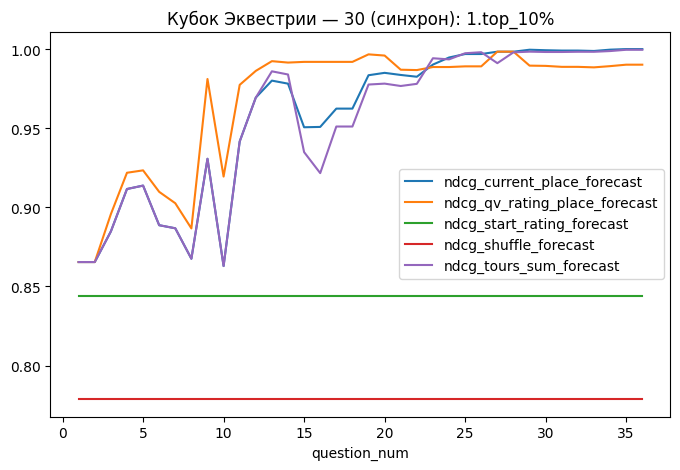

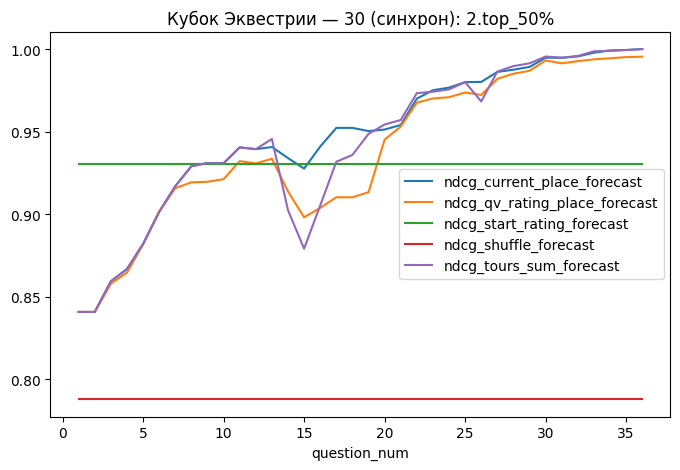

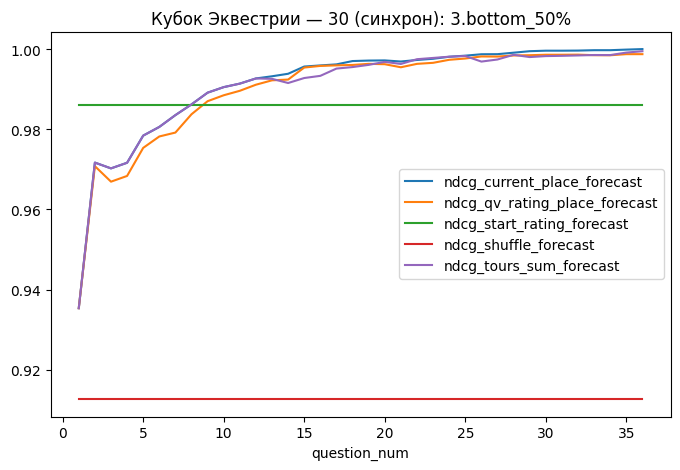

In [18]:
tourn_name = res_df['tourn_name'].values[0]
for segment in res_df['segment'].unique():
    res_df[res_df['segment'] == segment].set_index('question_num')[[
                                                                    'ndcg_current_place_forecast', 
                                                                    'ndcg_qv_rating_place_forecast',
                                                                    'ndcg_start_rating_forecast', 
                                                                    'ndcg_shuffle_forecast', 
                                                                    'ndcg_tours_sum_forecast'
                                                                    ]].plot(
                                                                        title=tourn_name+": "+segment,
                                                                            )

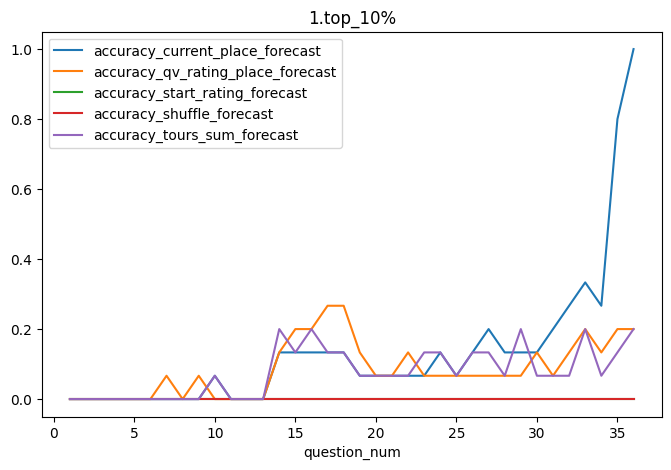

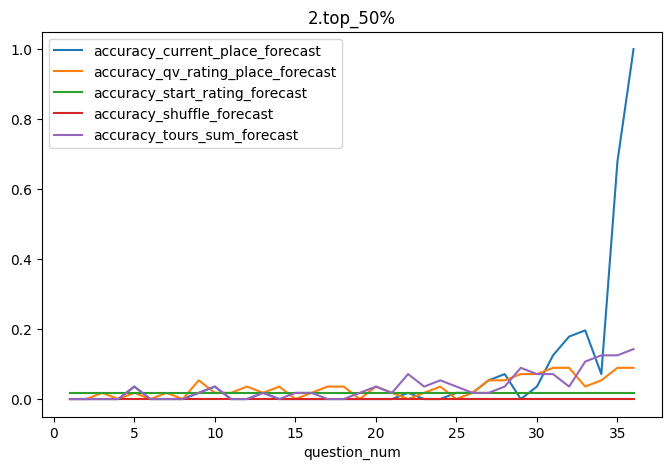

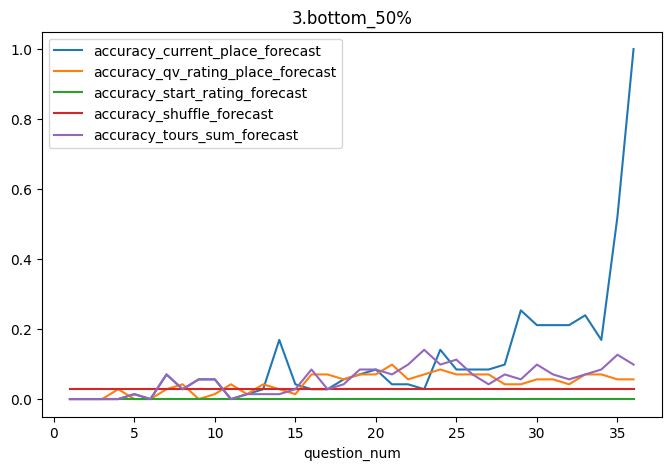

In [19]:
for segment in res_df['segment'].unique():
    res_df[res_df['segment'] == segment].set_index('question_num')[[
                                                                    'accuracy_current_place_forecast', 
                                                                    'accuracy_qv_rating_place_forecast',
                                                                    'accuracy_start_rating_forecast', 
                                                                    'accuracy_shuffle_forecast', 
                                                                    'accuracy_tours_sum_forecast'
                                                                    ]].plot(title=segment)

In [20]:
forec_df.set_index('segment')[[                                                                    
                                'ndcg_current_place_forecast', 
                                'ndcg_qv_rating_place_forecast',
                                'ndcg_start_rating_forecast', 
                                'ndcg_shuffle_forecast', 'ndcg_tours_sum_forecast'
                                ]].T

segment,1.top_10%,2.top_50%,3.bottom_50%
ndcg_current_place_forecast,0.998345,0.987507,0.999098
ndcg_qv_rating_place_forecast,0.998374,0.985081,0.998406
ndcg_start_rating_forecast,0.844213,0.930583,0.986015
ndcg_shuffle_forecast,0.778828,0.787924,0.912666
ndcg_tours_sum_forecast,0.997943,0.989691,0.998571


### Основной датасет
Загрузка больших данных, на которых та или иная стата уже показательна

In [21]:
# забор данных, может быть долгим (около 4 часов)
# в том числе из-за ограничений API
# если есть возможность, ставим data_work_option = 'file'
res_df, forec_df, tourn_lst_df = make_main_process(data_work_option, start_date, finish_date)

In [22]:
forec_df['tourn_id'].nunique()

1624

In [23]:
make_norm_metrics(forec_df, 'segment')[['segment', 'size', 'ndcg_start_rating_forecast']]

,segment,size,ndcg_start_rating_forecast
0,1.top_10%,14596,0.828767
1,2.top_50%,57423,0.887593
2,3.bottom_50%,60369,0.972730


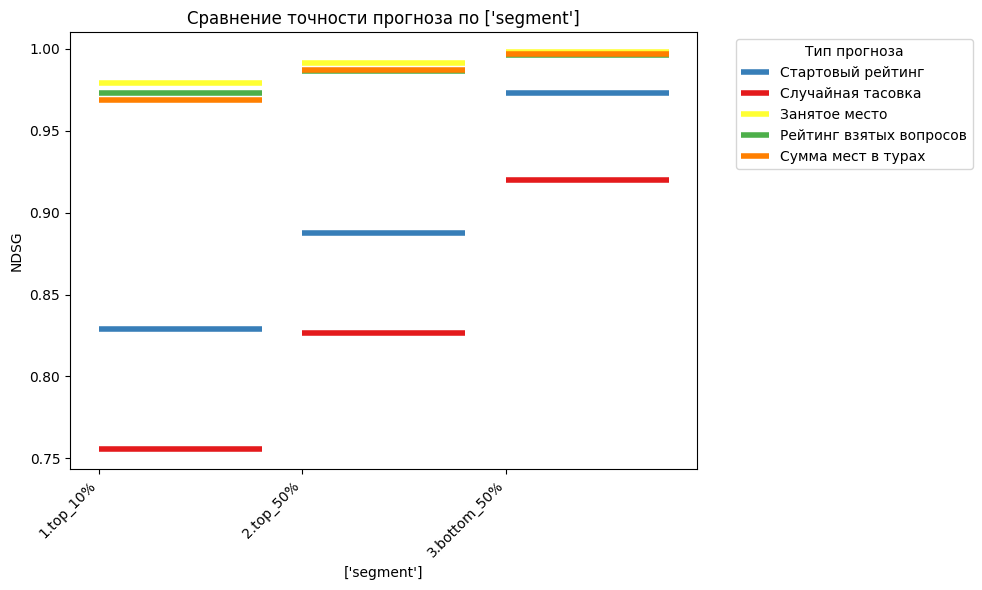

In [24]:
make_base_vis(forec_df, ['segment'], metric_dict)

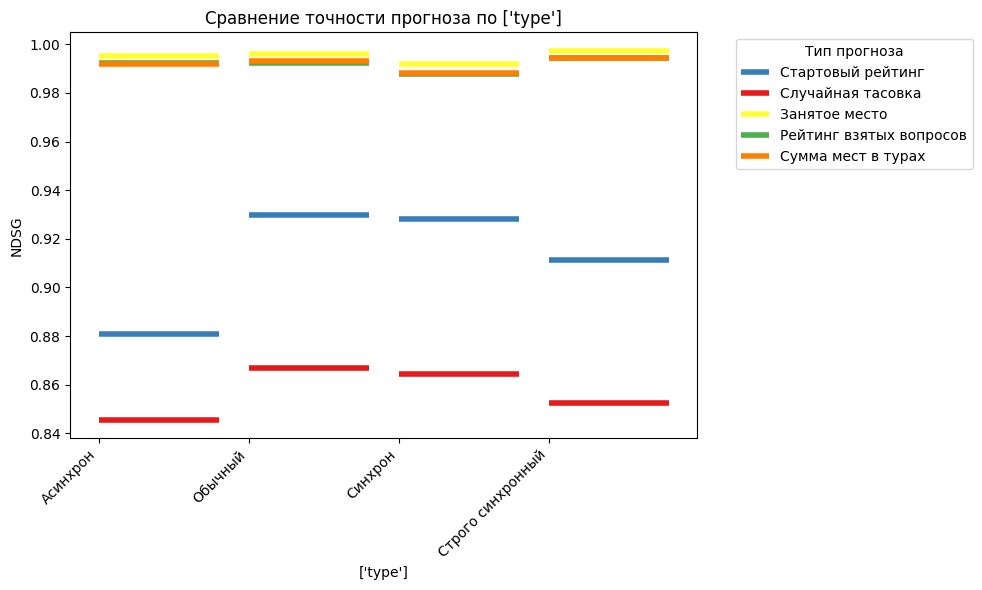

In [25]:
make_base_vis(forec_df, ['type'], metric_dict)

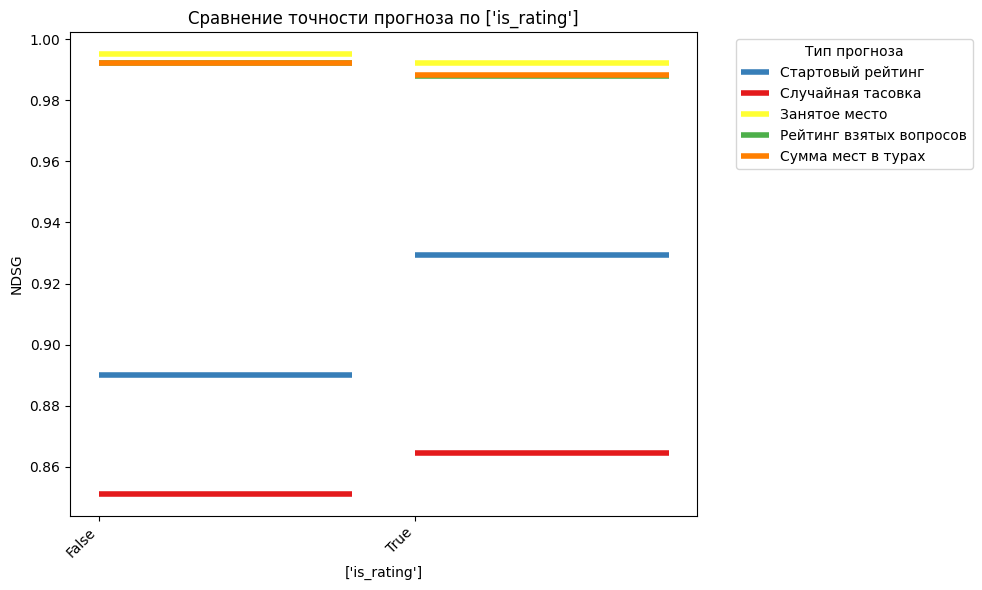

In [26]:
make_base_vis(forec_df, ['is_rating'], metric_dict)

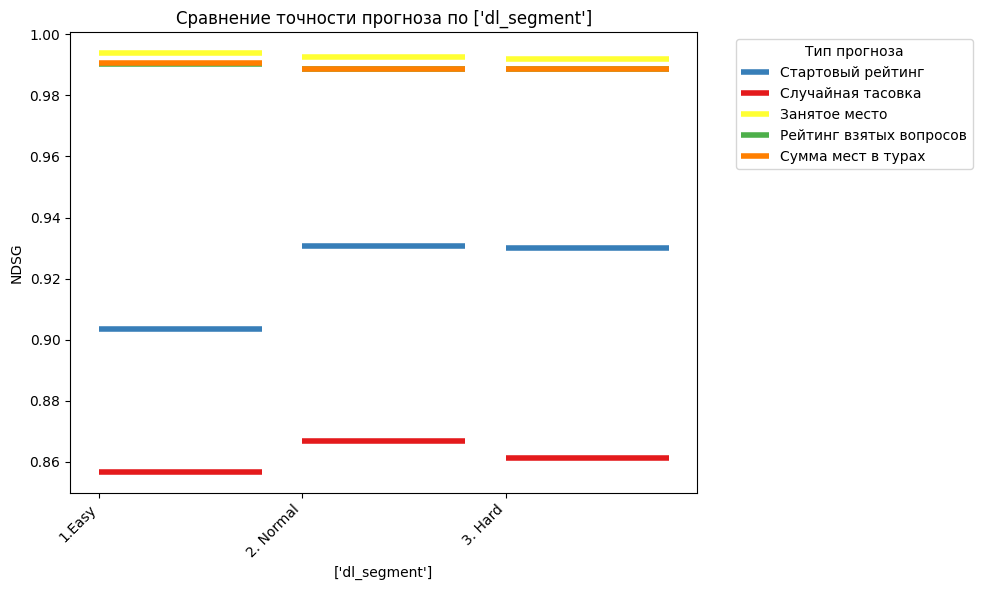

In [27]:
make_base_vis(forec_df, ['dl_segment'], metric_dict)

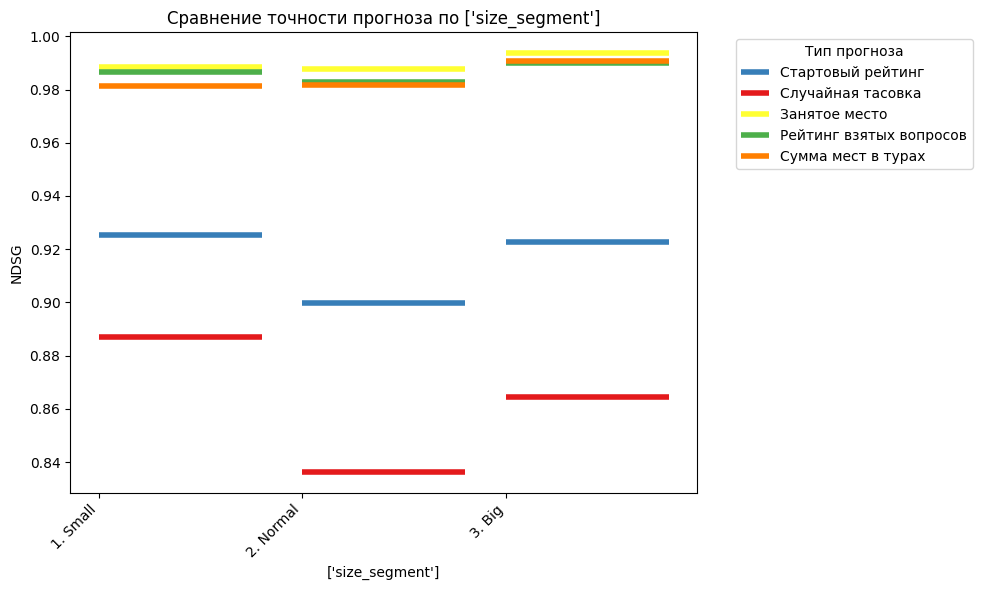

In [28]:
make_base_vis(forec_df, ['size_segment'], metric_dict)

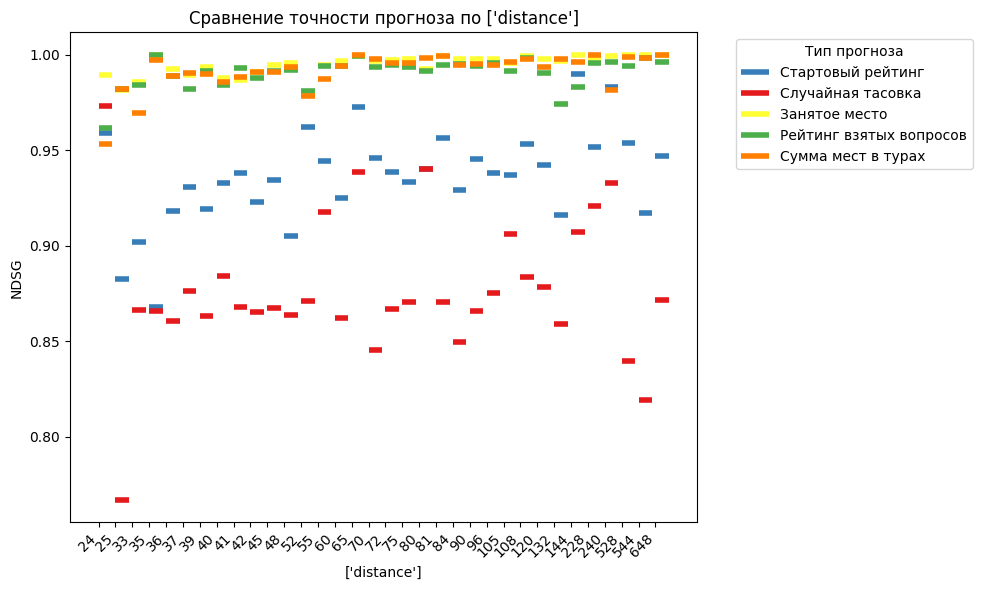

In [29]:
make_base_vis(forec_df, ['distance'], metric_dict)

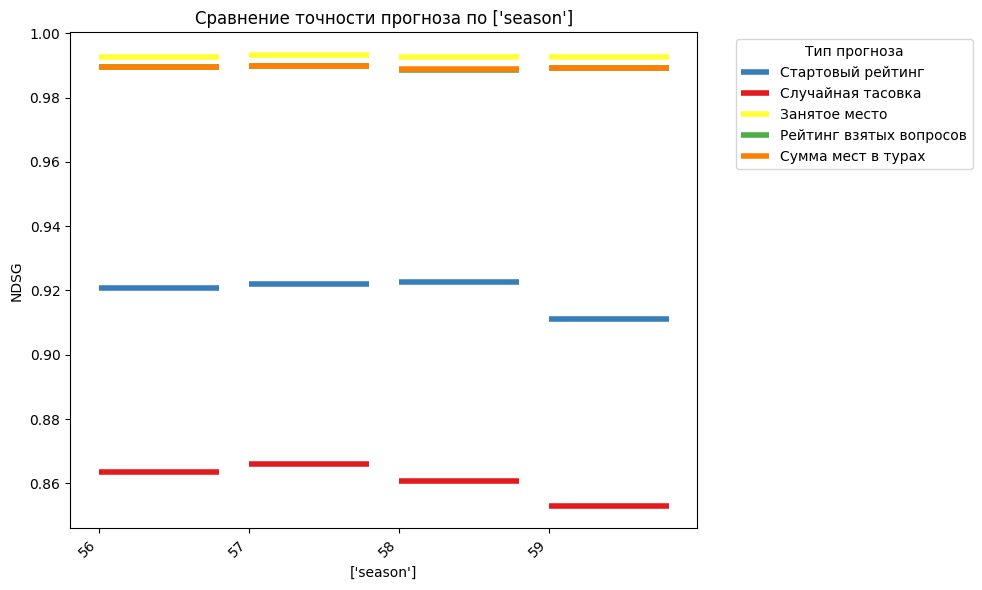

In [30]:
make_base_vis(forec_df, ['season'], metric_dict)

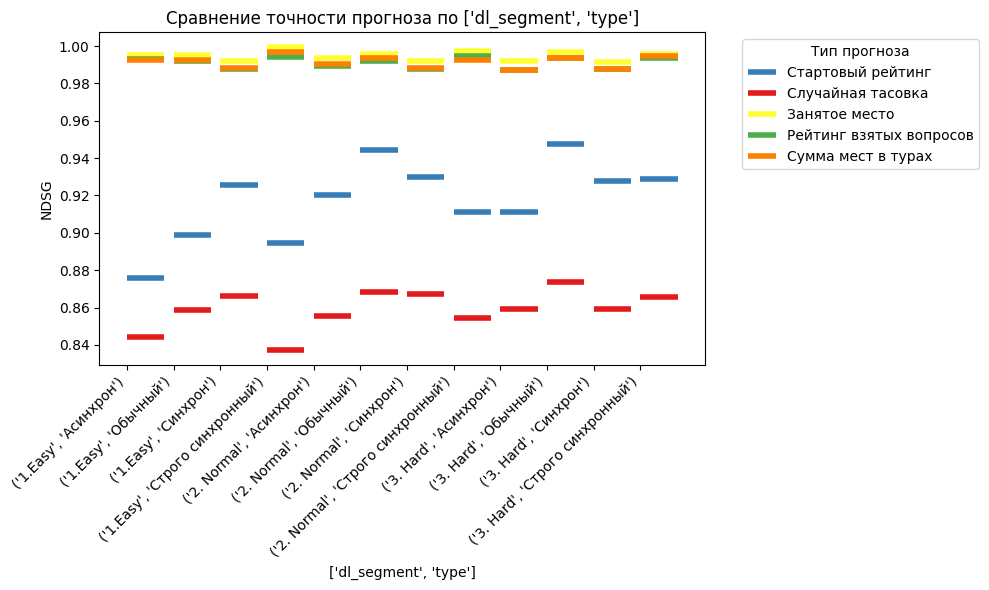

In [31]:
make_base_vis(forec_df, ['dl_segment', 'type'], metric_dict)

In [32]:
worked_df = forec_df[
                    (forec_df['is_rating'] == True) &
                    (forec_df['type'] != 'Асинхрон ') &
                    (forec_df['size'] > 10)
                    ]

In [33]:
forec_df['tourn_id'].nunique()

1624

In [34]:
worked_df['tourn_id'].nunique()

1016

/tmp/ipykernel_33360/2651073919.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  worked_df['trueDL'] = np.round(worked_df['trueDL'], 1)


<Axes: xlabel='trueDL'>

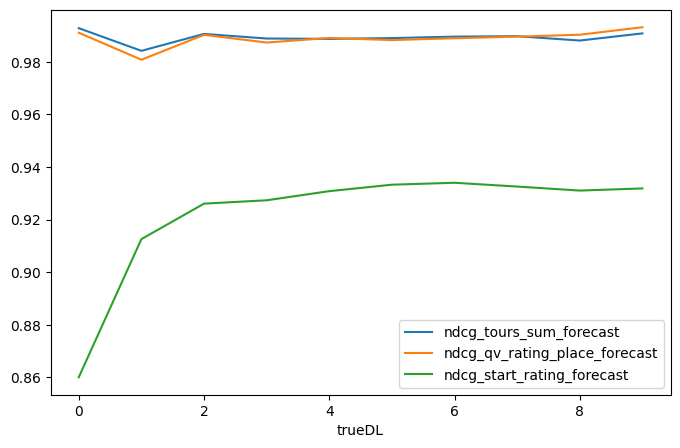

In [58]:
worked_df['trueDL'] = np.round(worked_df['trueDL'], 1)
dl_df = make_norm_metrics(worked_df, 'trueDL').set_index('trueDL')
dl_df[['ndcg_tours_sum_forecast', 'ndcg_qv_rating_place_forecast', 'ndcg_start_rating_forecast']].plot()

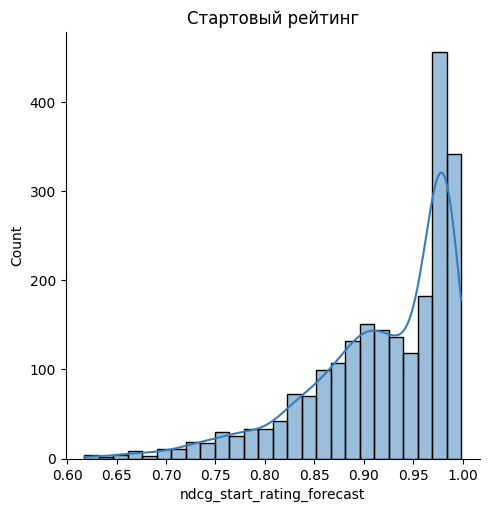

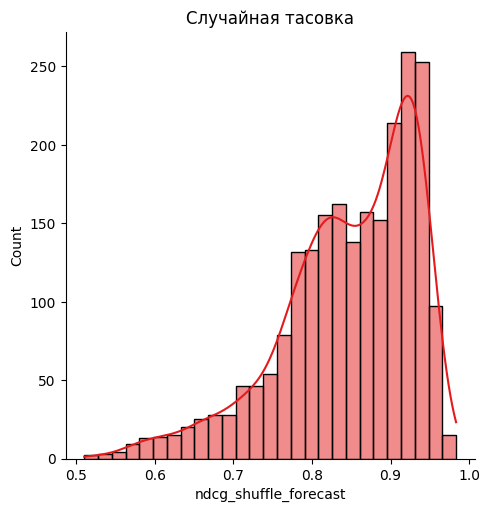

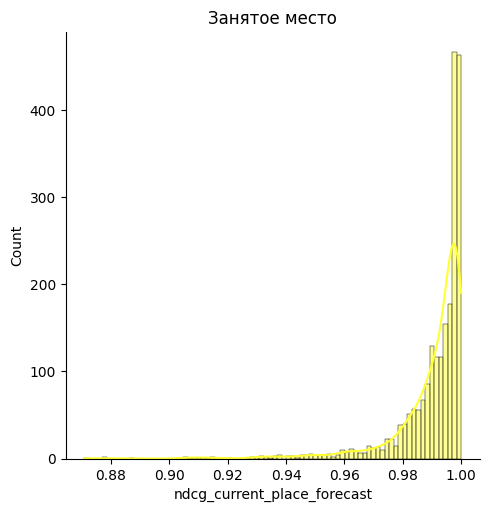

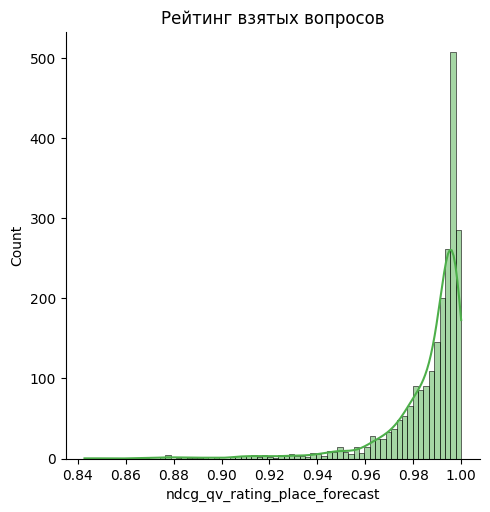

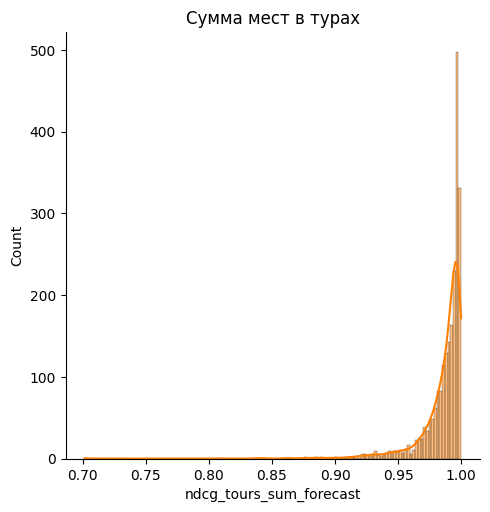

In [35]:
for metric in metric_dict.keys():
    sns.displot(data=worked_df, x=metric, kde=True, color=metric_dict[metric]['color'])
    plt.title(metric_dict[metric]['name'])

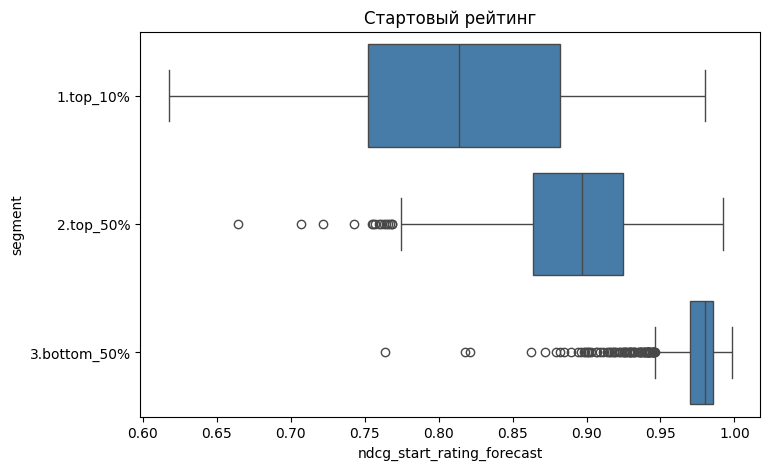

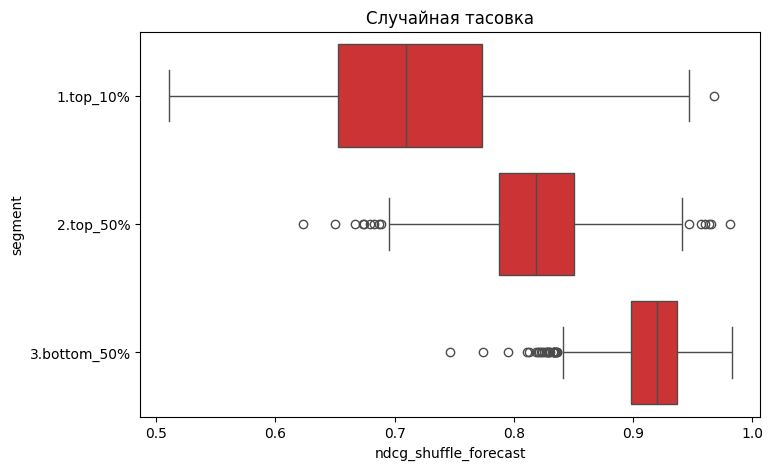

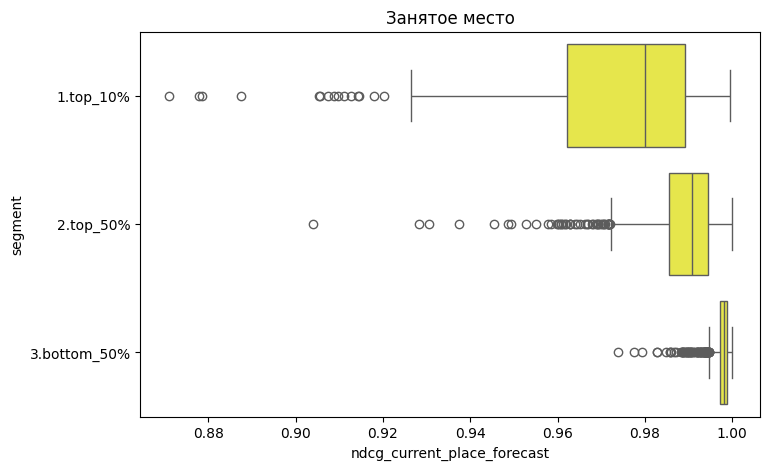

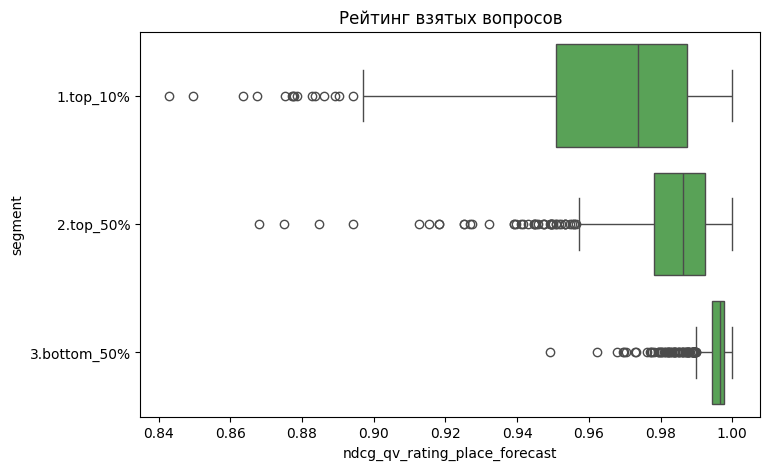

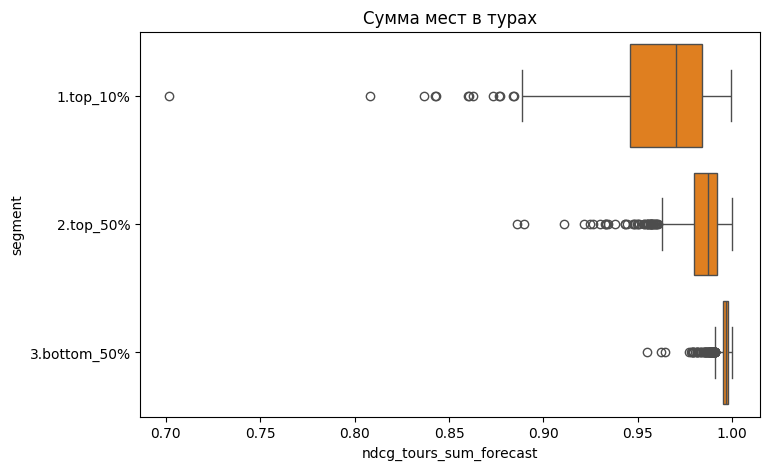

In [36]:
for metric in metric_dict.keys():
    sns.boxplot(data=worked_df, x=metric, y="segment", color=metric_dict[metric]['color'])
    plt.title(metric_dict[metric]['name'])
    plt.show()

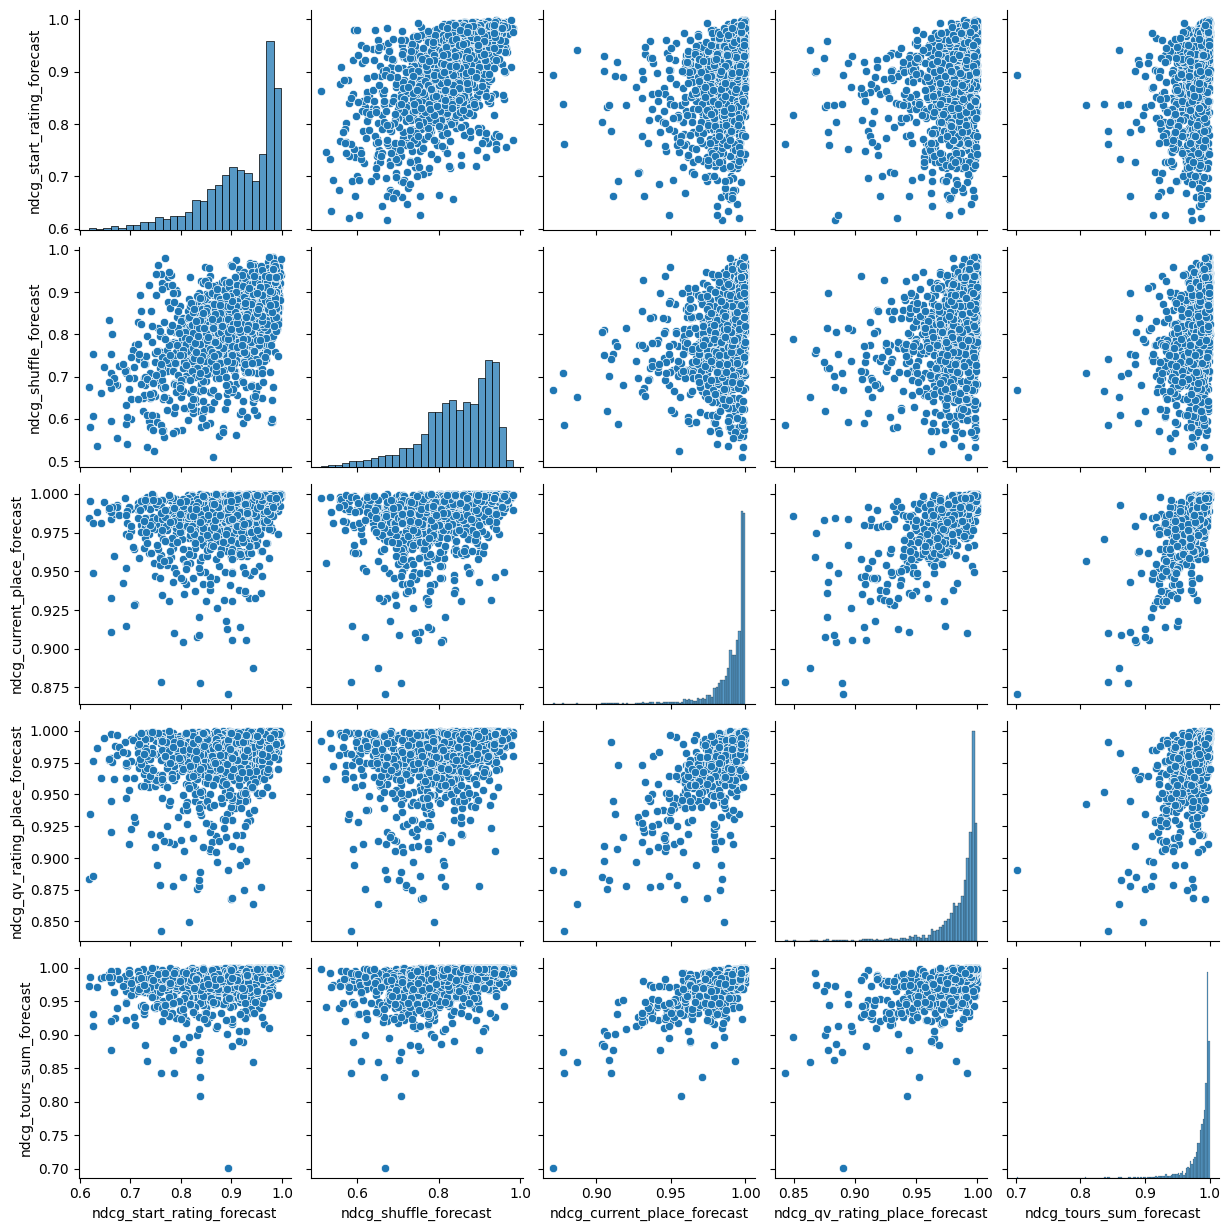

In [37]:
sns.pairplot(worked_df[metric_dict.keys()])

In [38]:
make_norm_metrics(worked_df, 'segment').set_index('segment')[metric_dict.keys()].T

segment,1.top_10%,2.top_50%,3.bottom_50%
ndcg_start_rating_forecast,0.810113,0.893502,0.978041
ndcg_shuffle_forecast,0.714384,0.822387,0.921648
ndcg_current_place_forecast,0.971869,0.989184,0.998018
ndcg_qv_rating_place_forecast,0.963404,0.983600,0.996129
ndcg_tours_sum_forecast,0.959312,0.984782,0.996670


### И ещё раз графики конкретных турниров

In [39]:
res_df = res_df.merge(tourn_lst_df, 'left', on='tourn_id')

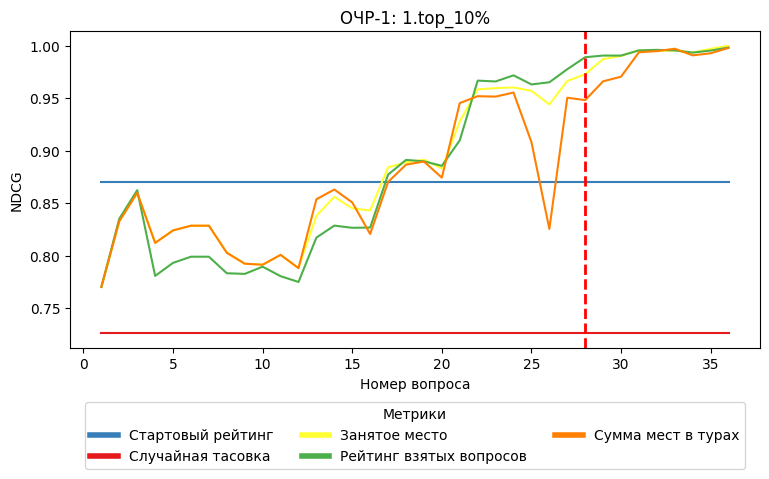

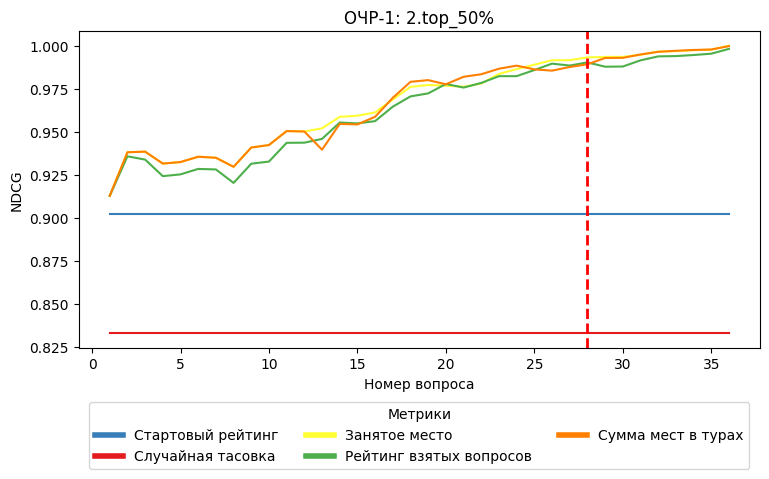

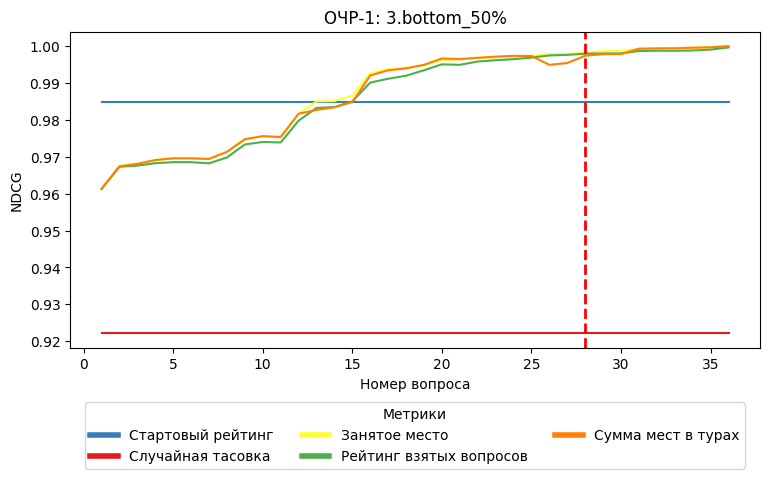

In [40]:
vis_one_tourn(res_df, 11427)

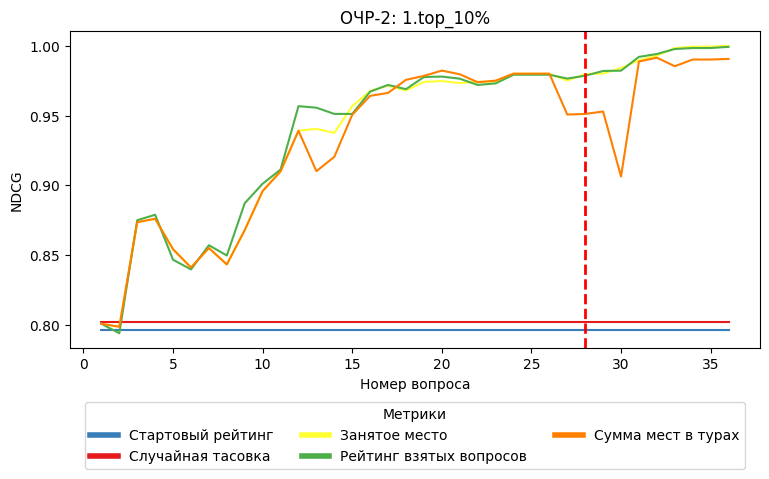

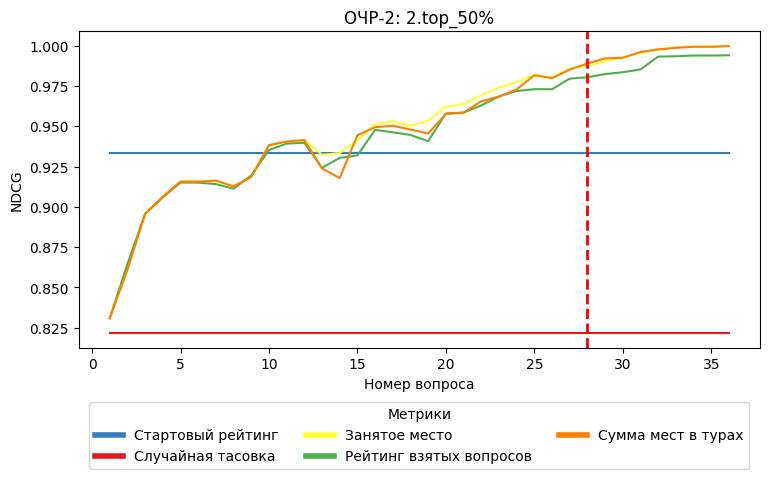

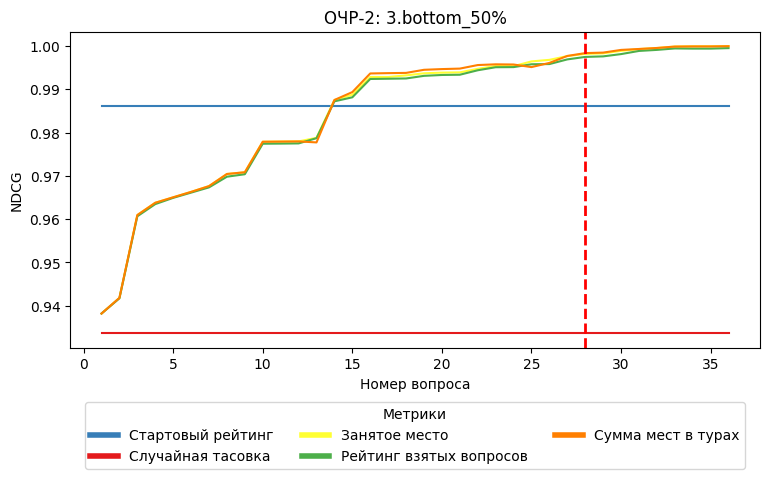

In [41]:
vis_one_tourn(res_df, 11454)

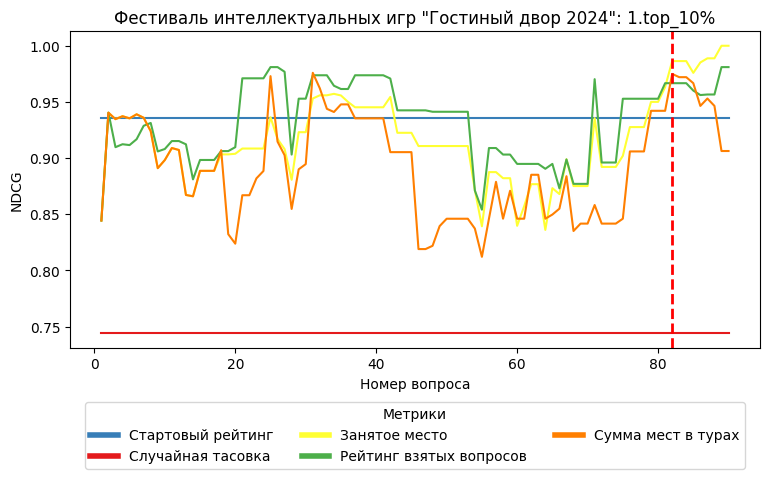

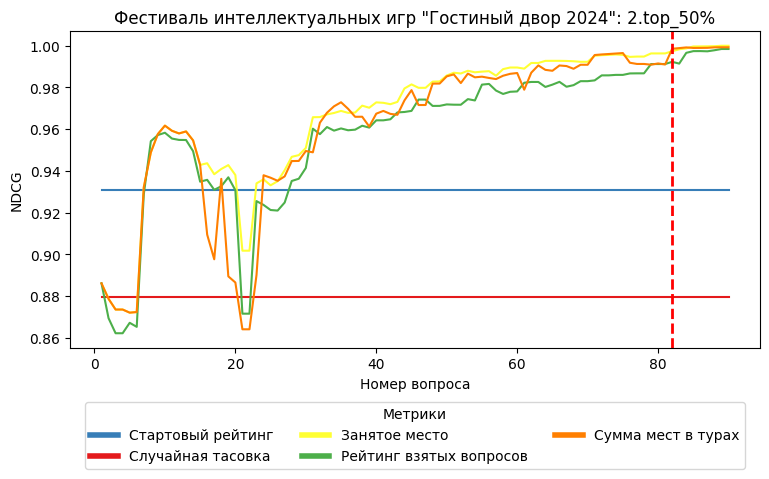

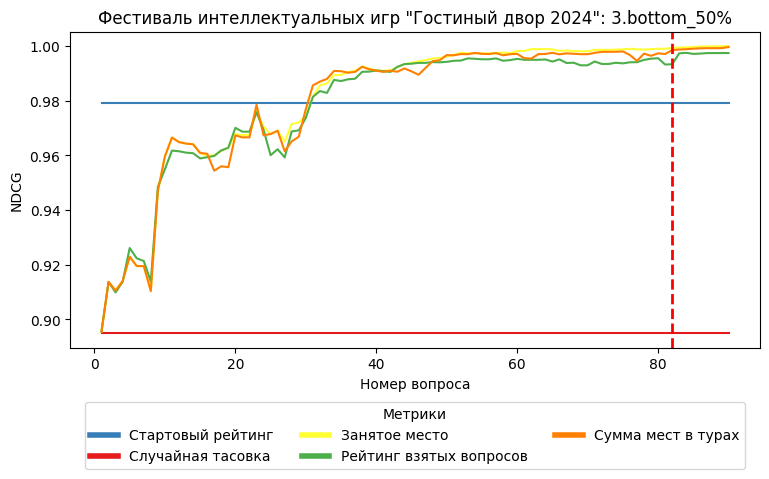

In [42]:
vis_one_tourn(res_df, 10707)

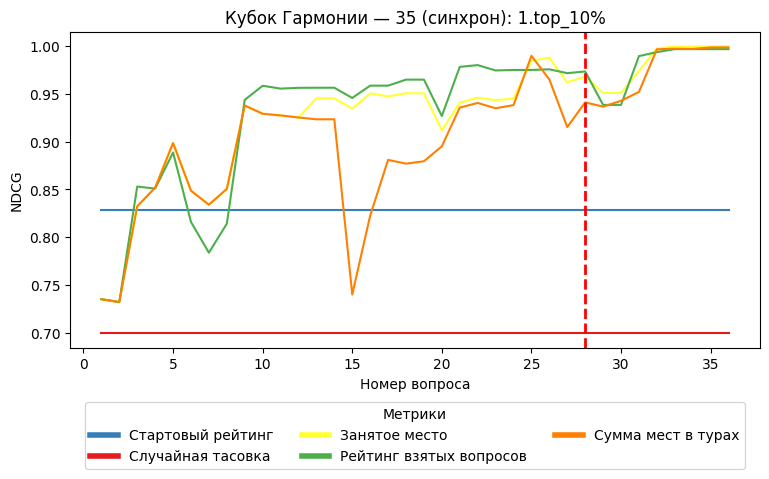

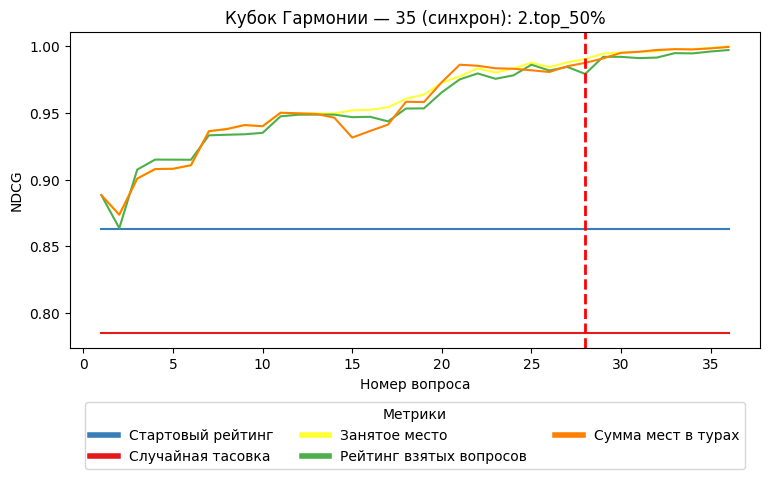

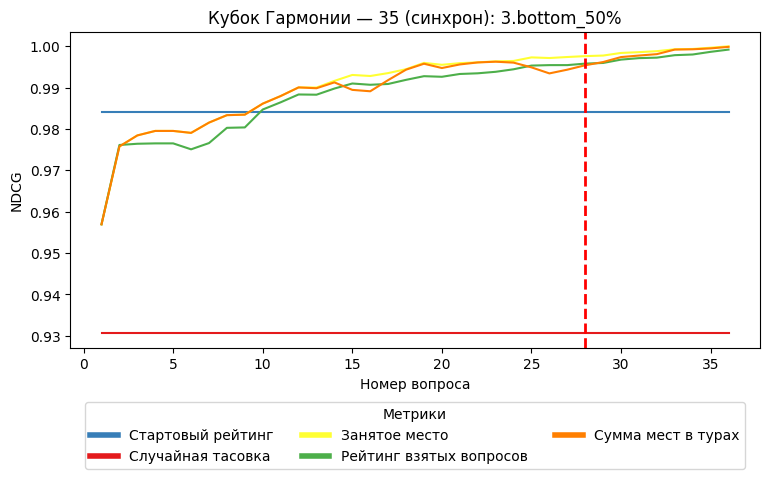

In [43]:
vis_one_tourn(res_df, 11108)